# **1.   Introduction**

The Collection and Delivery Problem of Biomedical Specimens (CDSP) arises in healthcare logistics, where biomedical samples, such as blood, plasma, and urine, must be transported from multiple points of care to a central laboratory for processing. This process is critical because timely delivery impacts the efficiency of laboratory diagnostics, which underpins most medical decisions.

In this short essay, we extract the CDSP from Rocha et al. (2024). They propose a two-index mixed-integer programming formulation using replenishment arcs, which outperforms both the state-of-the-art model and the state-of-the-art metaheuristic from the literature. The problem in the paper can be defined as follows: The laboratory owns a homogeneous fleet of vehicles. These vehicles depart from the depot (laboratory) and travel to locations to collect specimens within predetermined time-windows. After that, the specimens will be delivered back to the depot. If a vehicle arrives at a location before the time-window allowed for specimen pickup, it must wait at that location. If a vehicle arrives later, it cannot collect the specimen. Each location must be visited by one and only one vehicle. The objective is to ensure that the maximum number of specimens reach the laboratory as early as possible. Therefore, vehicles may make multiple trips, returning to the depot to deliver specimens before continuing their routes. There is a constraint for the shift of each vehicle: the shift of each vehicle, defined as the time span between its initial departure from the depot for the first trip and its return to the depot after the final trip, must not exceed a specified limit.

CDSP shares the characteristics of typical vehicle routing problems with multiple trips, multiple vehicles, and time-windows, but also has some differences to suit the nature of the problem:
* Instead of minimizing the makespan of all trips, our objective is to minimize the sum of delivery request completion times, enabling faster initiation of specimen processing and reducing overall diagnostic delays. In this context, the request completion time of a specimen refers to the time its arrival at the laboratory.
* Specimens require minimal storage space in vehicles. Therefore, capacity constraints for fleet of vehicles can be relaxed.
* Because of the urgency of the problem, the variable costs for transportation will be ignored.

In this essay, I use the idea of replenishment arcs derived from Rocha et al. (2024) to construct a dynamic programming algorithm for the CDSP. Additionally, the constraints for the shifts of vehicles in the original problem are relaxed. The model and algorithm can be used as the starting points for implementing more complex algorithms, such as (deep) reinforcement learning.

The content of the essay will be structured as follows: in chapter 2, a Markov Decision Process (MDP) will be defined for modeling the decision-making problems. In chapter 3, dynamic programming algorithms will be introduced. We will start with an algorithm using forward labeling. Then, methods including more efficient data types, dominance rules, and symmetry breaking will be applied to improve computational time. Computational results will be presented and evaluated in chapter 4. Chapter 5 will include conclusions and possible further research directions. Since the essay is written in Jupyter notebook format, code snippets of algorithms will be presented throughout the chapters.


# **2.	Markov Decision Process for CDSP**
Given k vehicles, a set of depot (indexed 0) and specimens indexed from 1 to n with (x_i,y_i) and (e_i,l_i) being the coordinates and time-window of location i, respectively, the CDSP can be formulated as a Markov Decision Process (MDP) with the following components:

<br>

**2.1. States (S):**

The state at any time t is represented as:

$
S_t = \left(
\begin{bmatrix}
\text{visited}_1 \\
\vdots \\
\text{visited}_k
\end{bmatrix},
\begin{bmatrix}
\text{current_node}_1 \\
\vdots \\
\text{current_node}_k
\end{bmatrix},
\begin{bmatrix}
\text{count}_1 \\
\vdots \\
\text{count}_k
\end{bmatrix},
\begin{bmatrix}
\text{time}_1 \\
\vdots \\
\text{time}_k
\end{bmatrix}
\right)
$

, where:
* $visited_i$: The ordered list corresponds to the nodes that vehicle i has visited. Here the depot index can be repeated multiple times.

* $\text{current_node}_i$: The current position of vehicle $i$.

* $count_i$: The number of specimens the vehicle has collected during the trip. The value will be set to $0$ if the vehicle is in the depot, indicating that all specimens have been delivered to the laboratory.

* $time_i$: The time at which the vehicle $i$ performs its operation (collects the specimen or delivers all specimens being kept for the laboratory) at current location.

Note that the set of unvisited locations (nodes) can be derived from the set of visited locations. This reduces the size of the state space. The terminal state will be the state where all the specimens have been collected and all the vehicles are at the depot.

<br>

**2.2. Actions ($X$):**

The action $x_t\in X(S_t)$ at time $t$, where $X(S_t)$ describes the set of all valid actions at state $S_t$ , is represented as:

$x_t=\left[\begin{matrix}next_1&\cdots&next_k\\\end{matrix}\right]$

Where $next_i$ corresponds to the next destination for vehicle $i$.

<br>

**2.3. 	Transition Function ($T$):**

The transition function determines the next state $S_{t+1}$ and the immediate cost $C$ given the current state $S_t$ and action $x_t$:

$T:\ \ S_t,x_t\rightarrow S_{t+1},C(S_t,S_{t+1})$

$S_{t+1}$ can be obtained by updating the vectors in $S_t$:
* Updating current_nodes to $x_t$.
* Updating time by adding times for going to new locations.
* Adding the locations in $x_t$ into visited.
* Resetting $count_i$ to $0$  if vehicle $i$ returns to the depot.

If vehicle i backs to the depot at $S_{t+1}$, a cost $C_i\left(S_t,S_{t+1}\right)=S_{t+1}\left(time_i\right)\ast S_t(count_i)$ incurrs. $C(S_t,S_{t+1})$ is calculated as the sum of the cost incurred for each vehicle.

<br>

**2.4. Policy($π$):**

The policy $\pi$ maps the state $S_t$ to an action $x_t$. The goal is to find the optimal policy $\pi^\ast$ that minimizes the total cost over the planning horizon. The cost function $C(S_t)$ is defined as cumulated cost up to state $S_t$. In our problem, the objective is to find the terminal state $S_{terminal}$ which has the minimum value of $C(S_{terminal})$.

<br>

We can observe that in this MDP the size of state space grows very rapidly with the number of vehicles and specimens, even when the set of valid actions at each state is well defined. For this reason, traditional dynamic programming implementations, where the entire state space is explored using recursive functions, become inefficient.

In the next chapter, algorithms using forward labeling will be proposed. Each label represents a partial solution, and only the most promising labels are propagated further to reduce computational effort. The use of labeling provides an efficient way to systematically explore and evaluate state and action spaces. It also makes it easier to apply methods for pruning suboptimal solutions and tracing back the optimal path.


#**3.	Implementation of Dynamic Programming using forward labeling**

In our first implementation, a dynamic programming algorithm using forward labeling works by iteratively generating states based on the current state and possible actions. The Python programming language will be used.

Each vector in the state or the action is implemented as a list. Without losing generality, the specimens indexes start from $0$ to $n-1$. $n$ will be the index of the depot. This makes the code more concise and makes it easier to see the number of specimens when looking at the result.

We expand feasible labels from a starting point toward goal states (all customers visited, and vehicles return to the depot). The initial label is created where all vehicles are at the depot, time and count are set to $0$ for all vehicles, and visited is empty. During this process, a $buffer$ (in the form of a dictionary) and a queue (in the form of a list) are used to store and explore the state space. The $buffer$ stores the cumulative cost $C(S_t)$ and the previous state $S_{t-1}$.

From the initial state, while the queue is not empty, the algorithm will generate all valid actions (using get_all_valid_actions) of state in queue, representing feasible movements of vehicles. Instead of assigning a large cost to invalid actions, the is_action_valid function is applied to check their validity. For an action to be valid, it must comply with customer time windows and avoid revisiting already served customers. This function helps avoid exploring towards infeasible states, significantly reducing the amount of state to process.

Then we apply each action to transition to a new state (using step_obs), updating the label components:

* New $\text{visited_nodes}$ based on destinations reached.
* Updated $\text{vehicle_travel_times}$ after moving to new destinations.
* Adjusted $\text{visited_count}$ and current_nodes based on visits to customers or the depot.

Then valid labels are added to the queue for further expansion. They are also stored in the buffer with their corresponding cost and parent label for backtracking. The algorithm continues until the queue is empty. The optimal solution is found by evaluating labels of terminal states where the cumulative cost is minimal. The pseudocode of the algorithm is as follows:

```plaintext
initial_state ← Instance's parameters
Buffer ← {initial_state: (0, None)}
Queue ← {initial_state}
while Queue is not empty:
    S ← Queue.pop()
    current_cost ← Buffer[S][0]
    for action in get_all_valid_actions(S):
        (S', cost) ← transition_function(S, action)
        Buffer[S'] ← (current_cost + cost, S)
        Queue.push(S')
end while
(best_path, best_cost) ← trace_back(Buffer)
return best_path, best_cost
```
The implementation of this algorithm **(Model 1)** is the following code snipset

In [1]:
import numpy as np
import pandas as pd
import itertools
import copy
import time
import heapq
from collections import defaultdict

In [2]:
def dynamic_programming_basic(num_vehicles, num_customers, depot_location, customer_locations, customer_time_windows):
    def get_state_key(state):
        return (
            tuple(frozenset(nodes) for nodes in state['visited_nodes']),
            tuple(state['current_nodes']),
            tuple(state['visited_count']),
            tuple(state['vehicle_travel_times']),
        )

    def step_obs(obs, action):
        obs_new = copy.deepcopy(obs)
        visited_nodes = obs_new['visited_nodes']
        current_nodes = obs_new['current_nodes']
        visited_counts = obs_new['visited_count']
        vehicle_travel_times = obs_new['vehicle_travel_times']
        unvisited_nodes = get_unvisited_nodes(visited_nodes)

        cost = float(0)
        info = {}

        if all(n == num_customers for n in current_nodes) and not np.any(unvisited_nodes):
            info["Done"] = True
            return obs_new, cost, True, False, info

        if not is_action_valid(action, unvisited_nodes, current_nodes, vehicle_travel_times):
            info["ValueError"] = "Invalid action"
            return obs_new, cost, False, False, info

        # Iterate through each vehicle and execute their action
        for vehicle_idx in range(num_vehicles):
            destination_idx = action[vehicle_idx]

            if current_nodes[vehicle_idx] == num_customers:
                current_position = np.array(depot_location)
            else:
                current_position = np.array(customer_locations[current_nodes[vehicle_idx]])

            # Determine destination's location
            if destination_idx == num_customers:
                destination = np.array(depot_location)
            else:
                destination = np.array(customer_locations[destination_idx])

            # Calculate travel time
            travel_time = np.linalg.norm(destination - current_position)
            vehicle_travel_times[vehicle_idx] += travel_time

            # If next node is the depot
            if destination_idx == num_customers:
                cost += (vehicle_travel_times[vehicle_idx] * visited_counts[vehicle_idx])
                visited_counts[vehicle_idx] = 0
                current_nodes[vehicle_idx] = destination_idx
                visited_nodes[vehicle_idx].add(destination_idx)
            # If next node is a customer
            if destination_idx < num_customers:
                if unvisited_nodes[destination_idx] == 1:
                    unvisited_nodes[destination_idx] = 0
                    start_time, end_time = customer_time_windows[destination_idx]
                    arrival_time = vehicle_travel_times[vehicle_idx]
                    if arrival_time < start_time:
                        vehicle_travel_times[vehicle_idx] = start_time
                    elif arrival_time > end_time:
                        return False
                    visited_counts[vehicle_idx] += 1
                    current_nodes[vehicle_idx] = destination_idx
                    visited_nodes[vehicle_idx].add(destination_idx)

        done = False
        if all(n == num_customers for n in current_nodes) and not np.any(unvisited_nodes):
            done = True

        next_obs = {
            "visited_nodes": visited_nodes,
            "current_nodes": current_nodes,
            "visited_count": visited_counts,
            "vehicle_travel_times": vehicle_travel_times,
        }

        return next_obs, cost, done, False, info

    def get_unvisited_nodes(visited_nodes):
        unvisited_nodes = np.ones(num_customers, dtype=int)
        for vehicle_idx in range(num_vehicles):
            for node in visited_nodes[vehicle_idx]:
                if 0 <= node < num_customers:
                    unvisited_nodes[node] = 0
        return unvisited_nodes

    def is_action_valid(action, unvisited, current, vehicle_travel_times):
        unvisited_nodes = unvisited.copy()
        current_nodes = current.copy()

        for node_idx in range(num_customers):
            temp = 0
            for a in action:
                if node_idx == a:
                    temp += 1
            if temp >= 2:
                return False

        for vehicle_idx in range(num_vehicles):
            destination_idx = action[vehicle_idx]

            # Validate action indices
            if not (0 <= destination_idx <= num_customers):
                return False
            # Check if the customer has already been visited by any vehicle
            if (destination_idx < num_customers
                    and unvisited_nodes[destination_idx] == 0):
                return False
            # Check if the arrival time exceeds the time window
            if destination_idx < num_customers:
                start_time, end_time = customer_time_windows[destination_idx]
                current_position = np.array(depot_location) if current_nodes[vehicle_idx] == num_customers else np.array(customer_locations[current_nodes[vehicle_idx]])
                destination = np.array(customer_locations[destination_idx])
                travel_time = np.linalg.norm(destination - current_position)
                arrival_time = vehicle_travel_times[vehicle_idx] + travel_time
                if arrival_time > end_time:
                    return False

        if all(i == num_customers for i in current_nodes) and all(a == num_customers for a in action):
            return False

        return True

    def get_all_valid_actions(unvisited, current, times):
        unvisited_nodes = unvisited.copy()
        current_nodes = current.copy()
        current_times = times.copy()
        valid_actions = []
        all_possible_actions = list(itertools.product(range(num_customers + 1), repeat=num_vehicles))

        for action in all_possible_actions:
            if is_action_valid(action, unvisited_nodes, current_nodes, current_times):
                valid_actions.append(list(action))

        return np.array(valid_actions)

    start_time = time.time()  # Start the timer

    initial_state = {
        "visited_nodes": [set() for _ in range(num_vehicles)],
        "current_nodes": [num_customers] * num_vehicles,
        "visited_count": [0] * num_vehicles,
        "vehicle_travel_times": [0.0] * num_vehicles,
    }
    initial_key = get_state_key(initial_state)
    buffer = {initial_key: (0, None)}
    queue = [initial_state]  # Store only state for tracking

    while queue:
        current_state = queue.pop(0)
        current_key = get_state_key(current_state)
        current_cost = buffer[current_key][0]

        unvisited_nodes = get_unvisited_nodes(current_state['visited_nodes'])
        valid_actions = get_all_valid_actions(unvisited_nodes, current_state['current_nodes'], current_state['vehicle_travel_times'])

        for action in valid_actions:
            next_state, action_cost, _, _, _ = step_obs(current_state, action)
            next_key = get_state_key(next_state)
            new_cost = current_cost + action_cost

            # Update buffer if new state or lower cost found
            if next_key not in buffer:
                buffer[next_key] = (new_cost, current_key)
                queue.append(next_state)
            else:
                if new_cost < buffer[next_key][0]:
                    buffer[next_key] = (new_cost, current_key)
                    queue.append(next_state)

    best_cost = float('inf')
    best_key = None

    # Find the optimal solution by iterating over the completed states
    for key in buffer.keys():
        visited_nodes, current_nodes, visited_count, vehicle_travel_times = key
        unvisited_nodes = get_unvisited_nodes([set(nodes) for nodes in visited_nodes])
        if all(node == 0 for node in unvisited_nodes) and all(node == num_customers for node in current_nodes):
            cost = buffer[key][0]
            if cost < best_cost:
                best_cost = cost
                best_key = key

    # Retrace the optimal path
    optimal_path = []
    while best_key is not None:
        optimal_path.append(best_key[1])  # Append current nodes of the best key
        best_key = buffer[best_key][1]  # Use previous nodes to trace back

    optimal_path = optimal_path[::-1]  # Reverse to get the correct order

    end_time = time.time()  # End the timer
    computational_time = end_time - start_time
    print(f"Computational Time: {computational_time} seconds")

    return best_cost, optimal_path, computational_time

We test the implementation with a small instance with 2 vehicles and 5 specimens. The locations and time-windows are randomly generated.

In [ ]:
num_vehicles = 2
num_customers = 5
depot_location = [0.5, 0.5]

np.random.seed(103093)
customer_locations = np.random.rand(25, 2)

customer_time_windows = [(0, 10), (5, 15), (10, 20), (0, 25), (20, 30),
                          (0, 10), (5, 15), (10, 20), (15, 25), (20, 30),
                          (0, 10), (5, 15), (10, 20), (15, 25), (20, 30),
                          (0, 10), (5, 15), (10, 20), (15, 25), (20, 30),
                          (0, 10), (5, 15), (10, 20), (15, 25), (20, 30)]

cost, route, computational_time = dynamic_programming_basic(num_vehicles, num_customers, depot_location, customer_locations, customer_time_windows)
print(cost)
print(route)
print(f"Computational Time: {computational_time} seconds")

Computational Time: 3.865105628967285 seconds
38.443680177138965
[(5, 5), (0, 3), (5, 5), (5, 1), (5, 5), (2, 4), (5, 5)]
Computational Time: 3.865105628967285 seconds


The optimal path will be:
* Vehicle 1: $Depot → 0 → Depot → 2 → Depot$
* Vehicle 2: $Depot → 3 → Depot → 1 → Depot → 4 → Depot$

Now we solve an instance with 3 vehicles and 5 specimens, the values ​of locations and time-windows are kept the same.

In [ ]:
num_vehicles = 3
num_customers = 5

cost, route, computational_time = dynamic_programming_basic(num_vehicles, num_customers, depot_location, customer_locations, customer_time_windows)
print(cost)
print(route)
print(f"Computational Time: {computational_time} seconds")

Computational Time: 49.64955496788025 seconds
38.44368017713896
[(5, 5, 5), (5, 1, 5), (5, 5, 5), (0, 4, 5), (5, 5, 5), (2, 5, 5), (5, 5, 3), (5, 5, 5)]
Computational Time: 49.64955496788025 seconds


Just by adding one more vehicle to the fleet, the computational time increases significantly as the size of state space increased. Therefore, some methods will be proposed to improve the performance. The code is given in advance.

In [3]:
def dynamic_programming_improved(num_vehicles,
                            num_customers,
                            depot_location,
                            customer_locations,
                            customer_time_windows,
                            use_dominance_rule_1=True,
                            use_dominance_rule_2=True,
                            use_tw_prunning=True,
                            use_symmetry_pruning=True
                            ):
    def get_state_key(state):
        # Keep state representation unchanged to avoid sorting vehicles for every state key
        return (
            tuple(frozenset(nodes) for nodes in state['visited_nodes']),
            tuple(state['current_nodes']),
            tuple(state['visited_count']),
            tuple(state['vehicle_travel_times']),
        )

    def step_obs(obs, action):
        obs_new = copy.deepcopy(obs)
        visited_nodes = obs_new['visited_nodes']
        current_nodes = obs_new['current_nodes']
        visited_counts = obs_new['visited_count']
        vehicle_travel_times = obs_new['vehicle_travel_times']
        unvisited_nodes = get_unvisited_nodes(visited_nodes)

        cost = float(0)
        info = {}

        if all(n == num_customers for n in current_nodes) and not np.any(unvisited_nodes):
            info["Done"] = True
            return obs_new, cost, True, False, info

        if not is_action_valid(action, unvisited_nodes, current_nodes, vehicle_travel_times):
            info["ValueError"] = "Invalid action"
            return obs_new, cost, False, False, info

        # Iterate through each vehicle and execute their action
        for vehicle_idx in range(num_vehicles):
            destination_idx = action[vehicle_idx]

            if current_nodes[vehicle_idx] == num_customers:
                current_position = np.array(depot_location)
            else:
                current_position = np.array(customer_locations[current_nodes[vehicle_idx]])

            # Determine destination's location
            if destination_idx == num_customers:
                destination = np.array(depot_location)
            else:
                destination = np.array(customer_locations[destination_idx])

            # Calculate travel time
            travel_time = np.linalg.norm(destination - current_position)
            vehicle_travel_times[vehicle_idx] += travel_time

            # If next node is the depot
            if destination_idx == num_customers:
                cost += (vehicle_travel_times[vehicle_idx] * visited_counts[vehicle_idx])
                visited_counts[vehicle_idx] = 0
                current_nodes[vehicle_idx] = destination_idx
                visited_nodes[vehicle_idx].add(destination_idx)
            # If next node is a customer
            if destination_idx < num_customers:
                if unvisited_nodes[destination_idx] == 1:
                    unvisited_nodes[destination_idx] = 0
                    start_time, end_time = customer_time_windows[destination_idx]
                    arrival_time = vehicle_travel_times[vehicle_idx]
                    if arrival_time < start_time:
                        vehicle_travel_times[vehicle_idx] = start_time
                    elif arrival_time > end_time:
                        return False
                    visited_counts[vehicle_idx] += 1
                    current_nodes[vehicle_idx] = destination_idx
                    visited_nodes[vehicle_idx].add(destination_idx)

        done = False
        if all(n == num_customers for n in current_nodes) and not np.any(unvisited_nodes):
            done = True

        next_obs = {
            "visited_nodes": visited_nodes,
            "current_nodes": current_nodes,
            "visited_count": visited_counts,
            "vehicle_travel_times": vehicle_travel_times,
        }

        return next_obs, cost, done, False, info

    def get_unvisited_nodes(visited_nodes):
        unvisited_nodes = np.ones(num_customers, dtype=int)
        for vehicle_idx in range(num_vehicles):
            for node in visited_nodes[vehicle_idx]:
                if 0 <= node < num_customers:
                    unvisited_nodes[node] = 0
        return unvisited_nodes

    def is_action_valid(action, unvisited, current, vehicle_travel_times):
        unvisited_nodes = unvisited.copy()
        current_nodes = current.copy()

        for node_idx in range(num_customers):
            temp = 0
            for a in action:
                if node_idx == a:
                    temp += 1
            if temp >= 2:
                return False

        for vehicle_idx in range(num_vehicles):
            destination_idx = action[vehicle_idx]

            # Validate action indices
            if not (0 <= destination_idx <= num_customers):
                return False
            # Check if the customer has already been visited by any vehicle
            if (destination_idx < num_customers
                    and unvisited_nodes[destination_idx] == 0):
                return False
            # Check if the arrival time exceeds the time window
            if destination_idx < num_customers:
                start_time, end_time = customer_time_windows[destination_idx]
                current_position = np.array(depot_location) if current_nodes[vehicle_idx] == num_customers else np.array(customer_locations[current_nodes[vehicle_idx]])
                destination = np.array(customer_locations[destination_idx])
                travel_time = np.linalg.norm(destination - current_position)
                arrival_time = vehicle_travel_times[vehicle_idx] + travel_time
                if arrival_time > end_time:
                    return False

        # Check for future feasibility of unvisited nodes
        if use_tw_prunning:
            for node_idx, is_unvisited in enumerate(unvisited_nodes):
                if is_unvisited:
                    min_arrival_times = [
                        vehicle_travel_times[vehicle_idx] + np.linalg.norm(
                            customer_locations[node_idx] -
                            (depot_location if current_nodes[vehicle_idx] == num_customers else customer_locations[current_nodes[vehicle_idx]])
                        )
                        for vehicle_idx in range(num_vehicles)
                    ]
                    earliest_arrival = min(min_arrival_times)
                    start_time, end_time = customer_time_windows[node_idx]
                    if earliest_arrival > end_time:
                        return False

        if all(i == num_customers for i in current_nodes) and all(a == num_customers for a in action):
            return False

        return True

    def get_all_valid_actions(unvisited, current, times):
        unvisited_nodes = unvisited.copy()
        current_nodes = current.copy()
        current_times = times.copy()
        valid_actions = []
        all_possible_actions = list(itertools.product(range(num_customers + 1), repeat=num_vehicles))

        for action in all_possible_actions:
            if is_action_valid(action, unvisited_nodes, current_nodes, current_times):
                valid_actions.append(list(action))

        return np.array(valid_actions)

    start_time = time.time()  # Start the timer

    initial_state = {
        "visited_nodes": [set() for _ in range(num_vehicles)],
        "current_nodes": [num_customers] * num_vehicles,
        "visited_count": [0] * num_vehicles,
        "vehicle_travel_times": [0.0] * num_vehicles,
    }
    initial_key = get_state_key(initial_state)
    buffer = defaultdict(lambda: (float('inf'), None))  # Use defaultdict to initialize default values for buffer
    buffer[initial_key] = (0, None)
    priority_queue = [(0, initial_key, initial_state)]  # Use a priority queue to store (cost, state_key, state) tuples

    # Track a reduced set of representative states for symmetry checks
    representative_states = set()

    while priority_queue:
        current_cost, current_key, current_state = heapq.heappop(priority_queue)

        if current_cost > buffer[current_key][0]:
            continue

        unvisited_nodes = get_unvisited_nodes(current_state['visited_nodes'])
        valid_actions = get_all_valid_actions(unvisited_nodes, current_state['current_nodes'], current_state['vehicle_travel_times'])

        for action in valid_actions:
            next_state, action_cost, _, _, _ = step_obs(current_state, action)
            next_key = get_state_key(next_state)
            new_cost = current_cost + action_cost

            # Symmetry pruning
            if use_symmetry_pruning:
                if not all(n == num_customers for n in next_state['current_nodes']):
                    hash_next_state = hash(tuple(sorted((tuple(next_state['visited_nodes'][i]),
                                                    next_state['current_nodes'][i],
                                                    next_state['visited_count'][i],
                                                    next_state['vehicle_travel_times'][i])
                                                for i in range(num_vehicles))))
                    if hash_next_state in representative_states:
                        continue
                    representative_states.add(hash_next_state)

            # Dominance rule: prune states with higher cost
            if use_dominance_rule_1:
                if next_key in buffer:
                    if new_cost >= buffer[next_key][0]:
                        continue

            # Additional dominance rule: if all vehicles are at depot and visited nodes are the same
            if use_dominance_rule_2:
                if all(node == num_customers for node in next_state['current_nodes']):
                    existing_keys = [k for k in buffer.keys() if k[0] == next_key[0] and all(n == num_customers for n in k[1])]
                    dominated = False
                    for existing_key in existing_keys:
                        if buffer[existing_key][0] <= new_cost:
                            dominated = True
                            break
                    if dominated:
                        continue
                    else:
                        for existing_key in existing_keys:
                            del buffer[existing_key]
                            existing_state = next((q for _, k, q in priority_queue if k == existing_key), None)
                            if (buffer[existing_key][0], existing_key, existing_state) in priority_queue:
                                priority_queue.remove((buffer[existing_key][0], existing_key, existing_state))
                                heapq.heapify(priority_queue)

            buffer[next_key] = (new_cost, current_key)
            heapq.heappush(priority_queue, (new_cost, next_key, next_state))


    best_cost = float('inf')
    best_key = None

    for key in buffer.keys():
        visited_nodes, current_nodes, visited_count, vehicle_travel_times = key
        unvisited_nodes = get_unvisited_nodes([set(nodes) for nodes in visited_nodes])
        if all(node == 0 for node in unvisited_nodes) and all(node == num_customers for node in current_nodes):
            cost = buffer[key][0]
            if cost < best_cost:
                best_cost = cost
                best_key = key

    optimal_path = []
    while best_key is not None:
        optimal_path.append(best_key[1])
        best_key = buffer[best_key][1]

    optimal_path = optimal_path[::-1]  # Reverse to get the correct order

    end_time = time.time()  # End the timer
    computational_time = end_time - start_time
    print(f"Computational Time: {computational_time} seconds")

    return best_cost, optimal_path, computational_time

**3.1. Using more effective data structure:**

The speed of the algorithm is greatly affected by the time it takes to search and update the $buffer$ and the $queue$. Therefore, using more efficient data structures will improve computational time. So the first approach is to use **defaultdict** (in Python) instead of built-in dictionary for the $buffer$, and use **heap queue (also called priority queue)** instead of list for the $queue$.

**defaultdict** is better when dealing with large dictionaries (our case). This is because defaultdict automatically initializes keys with a default value upon creation, eliminating the need to explicitly check for key existence or assign default values manually. As a result, it streamlines operations that involve frequent key lookups and updates ([source](https://dev.to/jorjishasan/built-in-dictionary-vs-defaultdict-2pmh)).


A **heap queue** organizes elements by priority, retrieving or removing higher-priority elements before lower-priority ones. Here we use cummulative cost to prioritize exploring states with low costs first. The insertion and extraction of the smallest element is $O(log n)$ instead of $O(n log n)$ of buil-in list. This also makes approaches like prunning suboptimal states or applying dominance rule (which will be discussed later) more efficient by providing a good lowerbound earlier.

These two changes are served as a starting point for the remaining approaches.

**3.2. Symmetry-Pruning:**

Considering a homogeneous fleet, indexes of vehicles are interchangeable. Symmetry pruning identifies if two states are equivalent by hashing the sorted representation of these components. This ensures that permutations of the index of vehicles are treated as equivalent. This method becomes even more effective as the number of vehicles increases.

In [ ]:
num_vehicles = 2
num_customers = 5

cost, route, computational_time = dynamic_programming_improved(
    num_vehicles,
    num_customers,
    depot_location,
    customer_locations,
    customer_time_windows,
    use_dominance_rule_1=False,
    use_dominance_rule_2=False,
    use_tw_prunning=False,
    use_symmetry_pruning=True)

print(cost)
print(route)
print(f"Computational Time: {computational_time} seconds")

Computational Time: 1.6153004169464111 seconds
38.44368017713897
[(5, 5), (3, 5), (5, 0), (5, 2), (1, 5), (5, 5), (5, 4), (5, 5)]
Computational Time: 1.6153004169464111 seconds


The computational time reduced from 3.865 to 1.615 for instance with 2 vehicles and 5 specimens.

In [ ]:
num_vehicles = 3
num_customers = 5

cost, route, computational_time = dynamic_programming_improved(
    num_vehicles,
    num_customers,
    depot_location,
    customer_locations,
    customer_time_windows,
    use_dominance_rule_1=False,
    use_dominance_rule_2=False,
    use_tw_prunning=False,
    use_symmetry_pruning=True)

print(cost)
print(route)
print(f"Computational Time: {computational_time} seconds")

Computational Time: 9.843223571777344 seconds
38.443680177138965
[(5, 5, 5), (3, 5, 5), (5, 2, 5), (5, 5, 5), (1, 4, 0), (5, 5, 5)]
Computational Time: 9.843223571777344 seconds


The compuational time reduced more significant from 49.649 to 9.843 for instance with 3 vehicles and 5 specimens.

**3.3. Dominance rule 1 - pruning states with higher cumulative cost:**

A dominance rule is implemented to prune the states which are fully dominated. Two states with the same label, but one state is dominated if its cost is higher than the other.


In [ ]:
num_vehicles = 3
num_customers = 5

cost, route, computational_time = dynamic_programming_improved(
    num_vehicles,
    num_customers,
    depot_location,
    customer_locations,
    customer_time_windows,
    use_dominance_rule_1=True,
    use_dominance_rule_2=False,
    use_tw_prunning=False,
    use_symmetry_pruning=False)

print(cost)
print(route)
print(f"Computational Time: {computational_time} seconds")

Computational Time: 37.412883043289185 seconds
38.44368017713896
[(5, 5, 5), (5, 5, 1), (5, 5, 5), (5, 0, 4), (5, 5, 5), (5, 2, 5), (3, 5, 5), (5, 5, 5)]
Computational Time: 37.412883043289185 seconds


The compuational time reduced more significant from 49.649 to 37.413 for instance with 3 vehicles and 5 specimens.

**3.4. Dominance rule 2 - vehicles are at depot and same visited nodes:**

Inspired by Baldacci et al. (2012) and Tilk and Irnich (2017): Given two state where all vehicles are at the depot (time that the costs occur) and have identical set of visited nodes, a dominance rule is implemented to retain only the state with lower traveling times (for all vehicles). The correctness of this dominance rule can be proven by using the same path in the future when approaching unvisited nodes.

In [ ]:
num_vehicles = 2
num_customers = 5

cost, route, computational_time = dynamic_programming_improved(
    num_vehicles,
    num_customers,
    depot_location,
    customer_locations,
    customer_time_windows,
    use_dominance_rule_1=False,
    use_dominance_rule_2=True,
    use_tw_prunning=False,
    use_symmetry_pruning=False)

print(cost)
print(route)
print(f"Computational Time: {computational_time} seconds")

Computational Time: 14.32629108428955 seconds
38.443680177138965
[(5, 5), (3, 0), (5, 5), (5, 1), (5, 5), (2, 4), (5, 5)]
Computational Time: 14.32629108428955 seconds


The compuational time increased from 3.865 to 14.326 for instance with 2 vehicles and 5 specimens. This shows that the time reduction through reducing the size of the state space cannot compensate for the computation time of this function, especially when we have to search the entire $buffer$ with the condition.

**3.5. Pruning according to time-windows:**

In this method, we check for future considerations of appoaching unvisited locations when checking for valid actions. We determine if any unvisited customer nodes (from the perspective of all vehicles) can still be reached within their allowed time windows after taking the action. If no feasible path exists for a customer node due to its time window, the action leads to an infeasible state and will be eliminated from further exploration.

In [ ]:
num_vehicles = 2
num_customers = 5

cost, route, computational_time = dynamic_programming_improved(
    num_vehicles,
    num_customers,
    depot_location,
    customer_locations,
    customer_time_windows,
    use_dominance_rule_1=False,
    use_dominance_rule_2=False,
    use_tw_prunning=True,
    use_symmetry_pruning=False)

print(cost)
print(route)
print(f"Computational Time: {computational_time} seconds")

Computational Time: 20.352882385253906 seconds
38.443680177138965
[(5, 5), (0, 5), (5, 5), (2, 5), (5, 5), (4, 5), (5, 5), (5, 3), (5, 5), (5, 1), (5, 5)]
Computational Time: 20.352882385253906 seconds


The compuational time increased from 3.865 to 20.352 for instance with 2 vehicles and 5 specimens. The reason should be similar to when applying dominance rule 2, even with tighter time-windows.

Finally, we evaluate the performance of the algorithm using only proven methods, including symmetry pruning and dominance rule 1.

In [ ]:
num_vehicles = 2
num_customers = 5

cost, route, computational_time = dynamic_programming_improved(
    num_vehicles,
    num_customers,
    depot_location,
    customer_locations,
    customer_time_windows,
    use_dominance_rule_1=True,
    use_dominance_rule_2=False,
    use_tw_prunning=False,
    use_symmetry_pruning=True)

print(cost)
print(route)
print(f"Computational Time: {computational_time} seconds")

Computational Time: 1.3009347915649414 seconds
38.443680177138965
[(5, 5), (3, 5), (5, 0), (1, 5), (5, 5), (4, 2), (5, 5)]
Computational Time: 1.3009347915649414 seconds


In [ ]:
num_vehicles = 3
num_customers = 5

cost, route, computational_time = dynamic_programming_improved(
    num_vehicles,
    num_customers,
    depot_location,
    customer_locations,
    customer_time_windows,
    use_dominance_rule_1=True,
    use_dominance_rule_2=False,
    use_tw_prunning=False,
    use_symmetry_pruning=True)

print(cost)
print(route)
print(f"Computational Time: {computational_time} seconds")

Computational Time: 7.363787412643433 seconds
38.443680177138965
[(5, 5, 5), (0, 1, 5), (5, 5, 5), (4, 2, 3), (5, 5, 5)]
Computational Time: 7.363787412643433 seconds


It has been shown that for both instances, the combination of the two methods is superior to using either one alone, as well as better than the basic algorithm. Here is the pseudocode of the improved algirithm, in which the pruning and dominance rules are intergrated into $evaluate$ function:

```plaintext
initial_state ← Instance's parameters
Buffer ← {{initial_state: (0, None)}}
HeapQueue ← {0, initial_state}
Representative_states ← {}

while HeapQueue is not empty:
    (current_cost, S) ← HeapQueue.pop()
    for action in get_all_valid_actions(S):
        (S', cost) ← transition_function(S, action)
        evaluate(S', cost)
        if accepted:
            Buffer[S'] ← (current_cost + cost, S)
            HeapQueue.push(current_cost + cost, S')
end while

(best_path, best_cost) ← trace_back(Buffer)
return best_path, best_cost
```

# **4. Computational Experiments**

In this chapter, we evaluate the speed of the basic algorithm and the improved algorithm with more instances for a more comprehensive evaluation. Using the same data of locations and time-windows for the specimens, the instances contain 2 or 3 vehicles and the number of vehicles ranges from 3 to 7.

In [5]:
depot_location = [0.5, 0.5]
np.random.seed(42)
customer_locations = np.random.rand(25, 2)
customer_time_windows = [(0, 10), (5, 15), (10, 20), (0, 25), (20, 30),
                        (0, 10), (5, 15), (10, 20), (15, 25), (20, 30),
                        (0, 10), (5, 15), (10, 20), (15, 25), (20, 30),
                        (0, 10), (5, 15), (10, 20), (15, 25), (20, 30),
                        (0, 10), (5, 15), (10, 20), (15, 25), (20, 30)]

# Define the range for the number of vehicles and customers
num_vehicles_list = [2, 3]
num_customers_list = [i for i in range(3, 8)]

# Initialize an empty list to store results
results = []

for num_vehicles in num_vehicles_list:
    for num_customers in num_customers_list:
        # Subset customer data for the current number of customers
        current_customer_locations = customer_locations[:num_customers]
        current_time_windows = customer_time_windows[:num_customers]

        # Run the basic model
        cost_basic, route_basic, time_basic = dynamic_programming_basic(
            num_vehicles, num_customers, depot_location, current_customer_locations, current_time_windows
        )

        # Run the improved model
        cost_improved, route_improved, time_improved = dynamic_programming_improved(
            num_vehicles,
            num_customers,
            depot_location,
            customer_locations,
            customer_time_windows,
            use_dominance_rule_1=True,
            use_dominance_rule_2=False,
            use_tw_prunning=False,
            use_symmetry_pruning=True)

        results.append({
            'model': 'Basic',
            'num_vehicles': num_vehicles,
            'num_customers': num_customers,
            'cost': cost_basic,
            'time': time_basic
        })
        results.append({
            'model': 'Improved',
            'num_vehicles': num_vehicles,
            'num_customers': num_customers,
            'cost': cost_improved,
            'time': time_improved
        })

results_df = pd.DataFrame(results)
print(results_df)


Computational Time: 0.04252815246582031 seconds
Computational Time: 0.020285606384277344 seconds
Computational Time: 0.4191288948059082 seconds
Computational Time: 0.19658946990966797 seconds
Computational Time: 2.3336496353149414 seconds
Computational Time: 0.9816684722900391 seconds
Computational Time: 17.300128698349 seconds
Computational Time: 6.866317510604858 seconds
Computational Time: 196.07998752593994 seconds
Computational Time: 96.43487119674683 seconds
Computational Time: 0.2023329734802246 seconds
Computational Time: 0.05281567573547363 seconds
Computational Time: 4.112889051437378 seconds
Computational Time: 0.7497639656066895 seconds
Computational Time: 43.87856984138489 seconds
Computational Time: 6.548305511474609 seconds
Computational Time: 452.0072889328003 seconds
Computational Time: 60.21872353553772 seconds
Computational Time: 10089.768641471863 seconds
Computational Time: 924.8513872623444 seconds
       model  num_vehicles  num_customers       cost          time

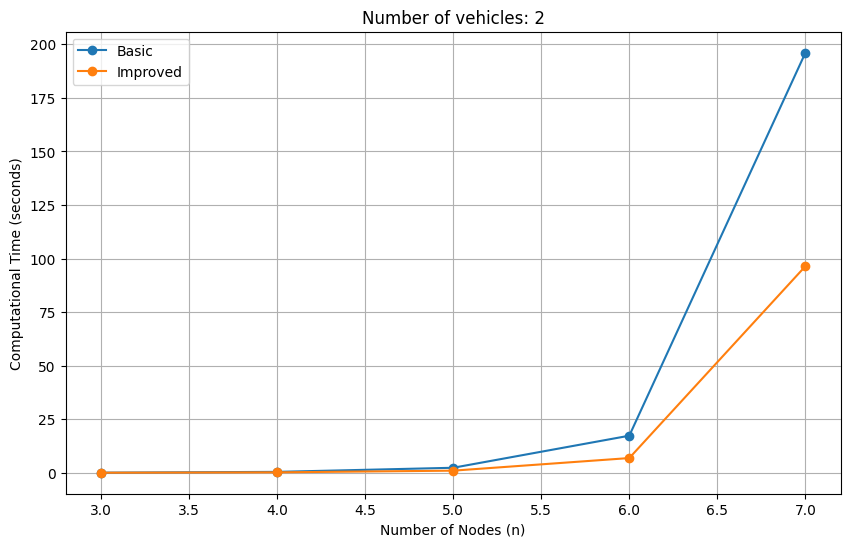

In [6]:
import matplotlib.pyplot as plt

df = pd.DataFrame(results_df)

# Filtering data by model
basic_model = df[(df['model'] == 'Basic') & (df['num_vehicles'] == 2)]
improved_model = df[(df['model'] == 'Improved') & (df['num_vehicles'] == 2)]

# Plotting the line chart
plt.figure(figsize=(10, 6))
plt.plot(basic_model['num_customers'], basic_model['time'], label='Basic', marker='o', linestyle='-')
plt.plot(improved_model['num_customers'], improved_model['time'], label='Improved', marker='o', linestyle='-')

plt.xlabel('Number of Nodes (n)')
plt.ylabel('Computational Time (seconds)')
plt.title('Number of vehicles: 2')
plt.legend()

plt.grid(True)
plt.show()

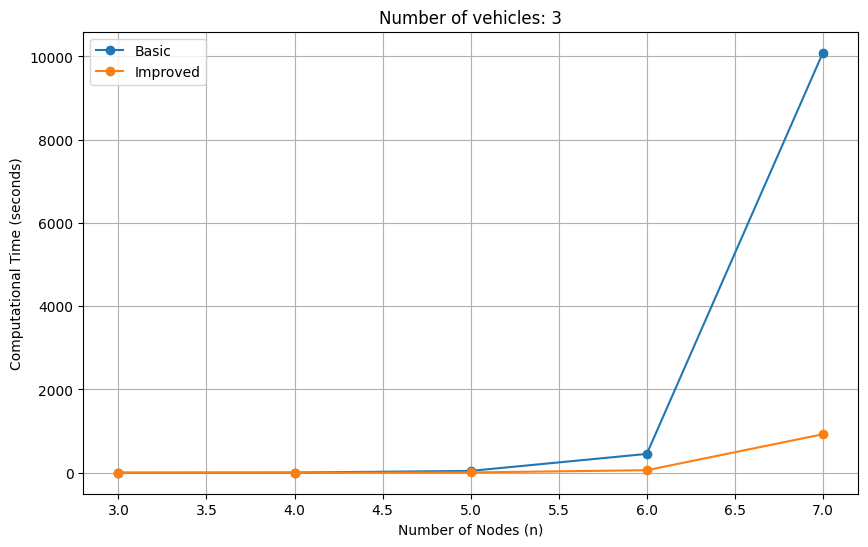

In [7]:
basic_model = df[(df['model'] == 'Basic') & (df['num_vehicles'] == 3)]
improved_model = df[(df['model'] == 'Improved') & (df['num_vehicles'] == 3)]

# Plotting the line chart
plt.figure(figsize=(10, 6))
plt.plot(basic_model['num_customers'], basic_model['time'], label='Basic', marker='o', linestyle='-')
plt.plot(improved_model['num_customers'], improved_model['time'], label='Improved', marker='o', linestyle='-')

plt.xlabel('Number of Nodes (n)')
plt.ylabel('Computational Time (seconds)')
plt.title('Number of vehicles: 3')
plt.legend()

plt.grid(True)
plt.show()

The result shows that we can achieve much better computational performances by using the improved model. The difference becomes increasingly clear when handling large instances. This understanding also shows that the big problem in when facing CDSP is the magnitude of the exponential increase in state space.

It can be seen that the basic model has difficulty handling the instance with a large number of vehicles. By adding just one vehicle to the fleet, the processing time increases from 196.078 to 10089.769, or nearly 50 times, for an instance with 7 specimens. The improved model handles this problem better thanks to the symmetry pruning function. The processing time increases from 96.435 to 924.851, or about 10 times.

# **5. Conclusion**

In this essay, we have implemented a dynamic programming algorithm using forward labeling to solve the Collection and Delivery Problem of Biomedical Specimens (CDSP) defined in Rocha et al. (2024). In addition, solutions to improve the algorithm are proposed and tested for their effectiveness. Among them, using symmetry pruning and dominance rule that only retaining the label with the smaller cost among similar labels has shown effectiveness in improving computational time. However, since the size of the state space increases quickly with increasing instance size, the proposed algorithm can only solve small instances of the problem.

In addition to the above improvement approaches, some other approaches can also be considered in future research. Baldacci et al. (2012) proposed a bidirectional labeling algorithm for the Traveling Salesman Problem with Time Windows, which can be considered for CDSP. However, considering multiple trips and multiple vehicles makes implementing backward labeling difficult. New dominance rules can also be investigated. However, along with that, the search for more efficient data structures is necessary.

Based on the proposed dynamic programming algorithm, ADP algorithms as well as Deep Reinforcement Learning can be developed, which is considered the main goal of this essay. In addition, the application of clustering for specimens based on location and time-windows proposed in Ferone et al. (2025) can be considered to implement heuristics that can produce near optimal solutions of good quality.



# **6. References**

[1] L. A. Rocha, A. Otto, and M. Goerigk, “A new formulation for the collection and delivery problem of biomedical specimen,” Aug. 19, 2024, arXiv: arXiv:2408.09998. Accessed: Oct. 31, 2024. [Online]. Available: http://arxiv.org/abs/2408.09998


[2] C. Tilk and S. Irnich, “Dynamic Programming for the Minimum Tour Duration Problem,” Transportation Science, vol. 51, no. 2, pp. 549–565, May 2017, doi: 10.1287/trsc.2015.0626.

[3] R. Baldacci, A. Mingozzi, and R. Roberti, “New State-Space Relaxations for Solving the Traveling Salesman Problem with Time Windows,” INFORMS Journal on Computing, vol. 24, no. 3, pp. 356–371, Aug. 2012, doi: 10.1287/ijoc.1110.0456.

[4] D. Ferone, P. Festa, S. Fugaro, and T. Pastore, “Hybridizing a matheuristic with ALNS for the optimal collection and delivery of medical specimens,” Int Trans Operational Res, vol. 32, no. 1, pp. 90–116, Jan. 2025, doi: 10.1111/itor.13386.

[5] G. Lera-Romero, J. J. Miranda Bront, and F. J. Soulignac, “Dynamic Programming for the Time-Dependent Traveling Salesman Problem with Time Windows,” INFORMS Journal on Computing, vol. 34, no. 6, pp. 3292–3308, Nov. 2022, doi: 10.1287/ijoc.2022.1236.

